In [1]:
import pandas as pd
import numpy as np
import os
import logging
from typing import Dict, List, Tuple, Optional, Union
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import warnings #for warnings
from obf_class import OBFDataset
import ml_models as ml 
import torch
import time
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve

In [2]:
# Suppress specific warnings
warnings.filterwarnings("ignore", message="is_sparse is deprecated")

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Configuration
data_directory = './obf_psy_dataset/'
groups_to_include = ['control', 'depression', 'schizophrenia']
# groups_to_include = ['control', 'depression', 'schizophrenia','adhd','clinical']

results_dir = './results'
models_dir = './models'
plots_dir = './plots'

# Create directories if they don't exist
for directory in [results_dir, models_dir, plots_dir]:
    os.makedirs(directory, exist_ok=True)

# Check for CUDA availability
cuda_available = torch.cuda.is_available()
if cuda_available:
    gpu_name = torch.cuda.get_device_name(0)
    logging.info(f"CUDA is available! Using GPU: {gpu_name}")
else:
    logging.info("CUDA is not available. Using CPU.")

# Load and prepare the dataset (do this only once)
logging.info("Loading and preprocessing dataset...")
start_time = time.time()
dataset = OBFDataset(data_directory, groups_to_include, save=True)
logging.info(f"Dataset loaded in {time.time() - start_time:.2f} seconds")

2025-03-19 15:56:53,440 - INFO - CUDA is available! Using GPU: NVIDIA GeForce RTX 3060 Laptop GPU
2025-03-19 15:56:53,440 - INFO - Loading and preprocessing dataset...
/home/anat/Documents/AI/sciences/mental/OBF_Psychiatric_a_motor_activity_dataset_of_patients_diagnosed_with_major_depression_schizophrenia_and_ADHD/obf_class.py:365: RuntimeWarning: divide by zero encountered in log
  L.append(np.log(Lk / k))
/home/anat/Documents/AI/sciences/mental/OBF_Psychiatric_a_motor_activity_dataset_of_patients_diagnosed_with_major_depression_schizophrenia_and_ADHD/obf_class.py:365: RuntimeWarning: divide by zero encountered in log
  L.append(np.log(Lk / k))
/home/anat/Documents/AI/sciences/mental/OBF_Psychiatric_a_motor_activity_dataset_of_patients_diagnosed_with_major_depression_schizophrenia_and_ADHD/obf_class.py:365: RuntimeWarning: divide by zero encountered in log
  L.append(np.log(Lk / k))
2025-03-19 15:57:05,749 - INFO - Loaded preprocessed data for group: adhd
2025-03-19 15:57:06,302 - INF

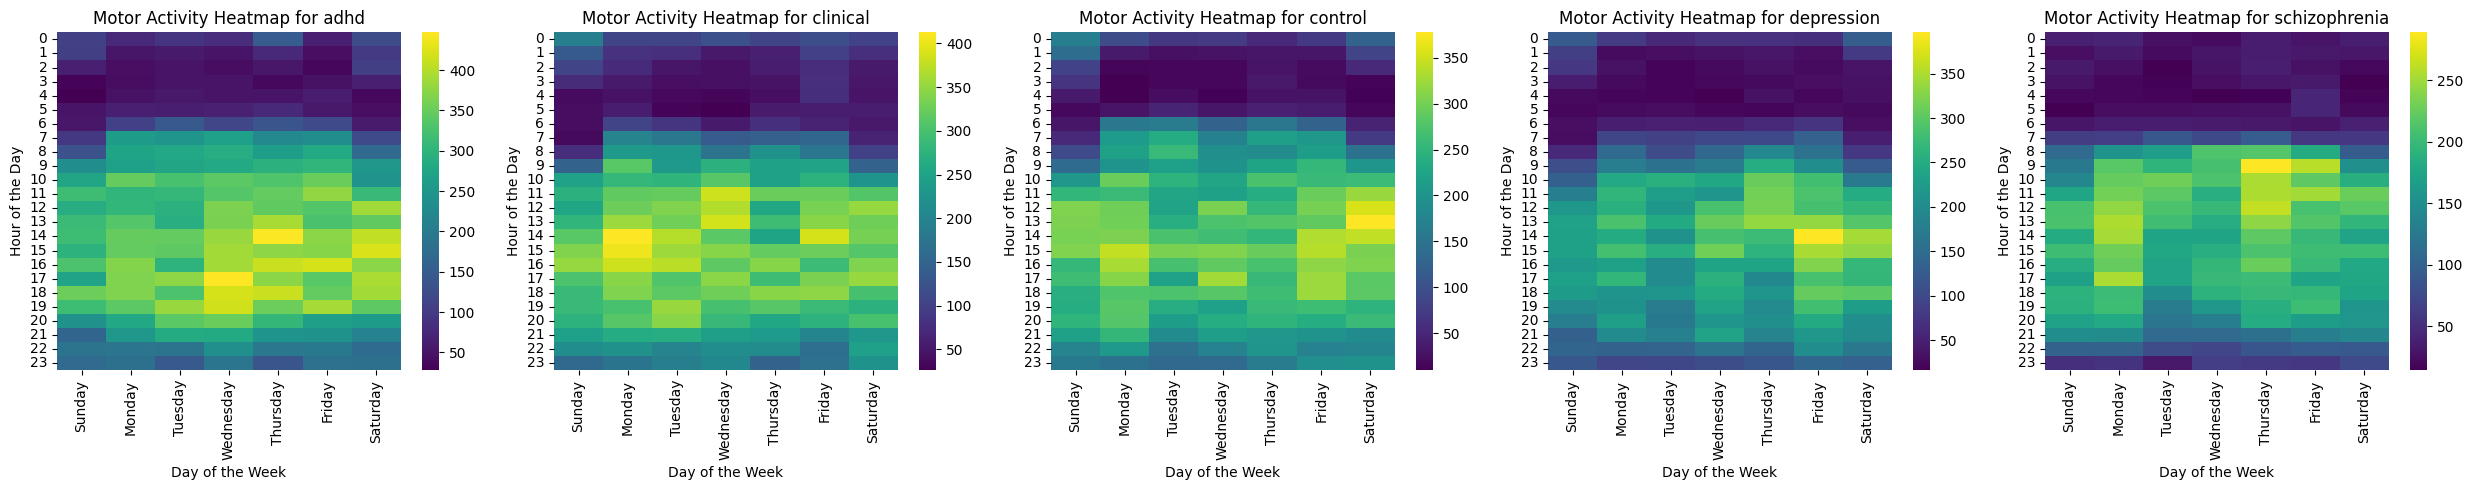

In [3]:
#Plot heatmap for a single group
# dataset.plot_activity_heatmap('depression')

#Plot heatmaps for all groups
dataset.plot_all_heatmaps()

# Plot heatmaps for a specific set of groups
# dataset.plot_all_heatmaps(['control', 'depression'])

In [4]:
# Extract features and labels
X = dataset.data[['daily_mean', 'daily_std', 'daily_median', 'daily_zeros', 'daily_25th',
                  'daily_75th', 'morning_mean', 'afternoon_mean', 'evening_mean',
                  'night_mean', 'dominant_freq', 'power_dominant_freq', 'rolling_mean_2h',
                  'rolling_std_2h', 'activity_lag_1', 'activity_lag_2',
                  'mean_std_interaction', 'median_zeros_interaction',
                  'log_daily_mean', 'sqrt_daily_std', 'square_daily_median','entropy','fractal_dimension']]
y = dataset.data['group']

# Create train-test split (do this once to ensure consistent evaluation)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
logging.info(f"Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")


2025-03-19 15:57:10,174 - INFO - Training set size: 1034, Test set size: 259


In [ ]:
# Run all classifiers and collect results
results = {}

# Run XGBoost (GPU-accelerated)
results['XGBoost'] = ml.run_xgboost(X_train, y_train, X_test, y_test,n_iter=1000)

# Run GPU Logistic Regression if CUDA is available
if cuda_available:
    results['LogisticRegression_GPU'] = ml.run_gpu_logistic_regression(X_train, y_train, X_test, y_test)

# Run Random Forest (CPU-based but multi-threaded)
results['RandomForest'] = ml.run_random_forest(X_train, y_train, X_test, y_test)

# Compare all models
comparison = ml.compare_models(results)
print("\n--- Final Model Comparison ---")
print(comparison)

# Identify best model
best_model_name = comparison.loc[comparison['Accuracy'].idxmax(), 'Model']
best_model_accuracy = comparison.loc[comparison['Accuracy'].idxmax(), 'Accuracy']
print(f"\nBest overall model: {best_model_name} (Accuracy = {best_model_accuracy:.4f})")

In [ ]:
# Train the ensemble model
ensemble_model, y_pred, y_proba = ml.train_ensemble_model(X_train, y_train, X_test, y_test, use_gpu=True)




### Continue training on saved model

In [ ]:
results = {}

import joblib

# Load the saved model
saved_model_path = './models/xgboost_best_model.pkl'
best_model = joblib.load(saved_model_path)

results['XGBoost_round_2'] = ml.run_xgboost(X_train, y_train, X_test, y_test,n_iter=1000,xgb_model=best_model)

In [7]:
from sklearn.utils.discovery import all_estimators
est = all_estimators(type_filter="classifier")

In [8]:
est

[('AdaBoostClassifier', sklearn.ensemble._weight_boosting.AdaBoostClassifier),
 ('BaggingClassifier', sklearn.ensemble._bagging.BaggingClassifier),
 ('BernoulliNB', sklearn.naive_bayes.BernoulliNB),
 ('CalibratedClassifierCV', sklearn.calibration.CalibratedClassifierCV),
 ('CategoricalNB', sklearn.naive_bayes.CategoricalNB),
 ('ClassifierChain', sklearn.multioutput.ClassifierChain),
 ('ComplementNB', sklearn.naive_bayes.ComplementNB),
 ('DecisionTreeClassifier', sklearn.tree._classes.DecisionTreeClassifier),
 ('DummyClassifier', sklearn.dummy.DummyClassifier),
 ('ExtraTreeClassifier', sklearn.tree._classes.ExtraTreeClassifier),
 ('ExtraTreesClassifier', sklearn.ensemble._forest.ExtraTreesClassifier),
 ('FixedThresholdClassifier',
  sklearn.model_selection._classification_threshold.FixedThresholdClassifier),
 ('GaussianNB', sklearn.naive_bayes.GaussianNB),
 ('GaussianProcessClassifier',
  sklearn.gaussian_process._gpc.GaussianProcessClassifier),
 ('GradientBoostingClassifier',
  sklearn